In [1]:
import sys
sys.path.append("../")
import PatternStructure as ps
import AssociativeNetwork as nt
from OrderParameterCalculator import OrderParameterCalculator
import functions as fs
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
from tqdm import tqdm
sns.set(style='white',font_scale=1.5)

In [14]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 10 # P
CELLS_PER_PATTERN = 100 
N_CHAINS = 2 # M
PATTERNS_PER_CHAIN = 2 # Q

DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

In [15]:
#Memory structure
kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
memories = ps.PatternStructure(n_cells=N_CELLS,
                            n_patterns=N_PATTERNS,
                            cells_per_pattern=CELLS_PER_PATTERN,
                            n_chains=N_CHAINS,
                            patterns_per_chain=PATTERNS_PER_CHAIN,
                            kernel=kernel)


memories.generate_patterns()
memories.generate_chains()
memories.build_interactions()

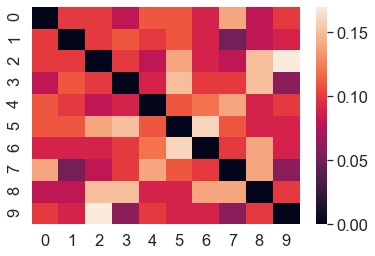

In [16]:
pattern_overlap = ps.pattern_overlap_matrix(memories)
sns.heatmap(pattern_overlap);

<AxesSubplot:title={'center':'transition matrix'}>

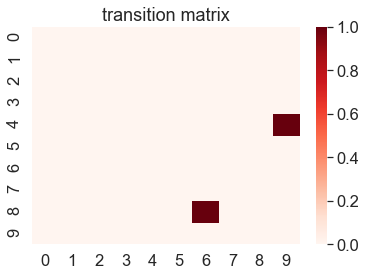

In [17]:
G = nx.from_numpy_matrix(memories.chain_transitions)
plt.title('transition matrix')
sns.heatmap(memories.chain_transitions,cmap=plt.cm.Reds)

In [18]:
starting_map = np.random.choice(N_PATTERNS)
net = nt.Network(J=memories.interaction_matrix, 
                 transfer_func=nt.ReLu,
                 dynamic_func=nt.net_dynamics)


In [19]:
initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
initial_config = initial_config/np.mean(initial_config)
net.run_dynamics(initial_config,n_steps=100,sparsity=DYNAMIC_SPARISTY)

In [20]:
order_params_tracker = OrderParameterCalculator(memories=memories,network=net)


In [21]:
order_params_tracker.compute_all_retrieval_probability()

0.98

In [22]:
order_params_tracker.compute_on_chain_retrieval_probability()

0.0

In [23]:
order_params_tracker.compute_off_chain_retrieval_probability()

0.98

In [24]:
coherence = order_params_tracker.coherence_timecourse
attractors = order_params_tracker.attractors_timecourse
retrieved_sequence = order_params_tracker.retrieved_sequence



Text(0, 0.5, 'pattern coherence')

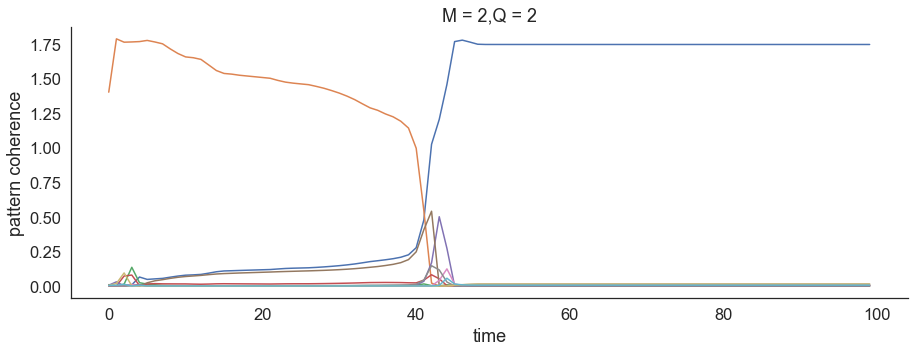

In [25]:
#retrieval_quality = fs.compute_retrieval_quality(coherence)
#obedience = fs.compute_obedience(retrieved_sequence,memories.chain_transitions)

plt.figure(figsize=(15,5))
for i,timecourse in enumerate(coherence):
    plt.plot(timecourse,label=f'pattern {i}')

sns.despine()
plt.title(f'M = {N_CHAINS},Q = {PATTERNS_PER_CHAIN}')
plt.xlabel('time')
plt.ylabel('pattern coherence')

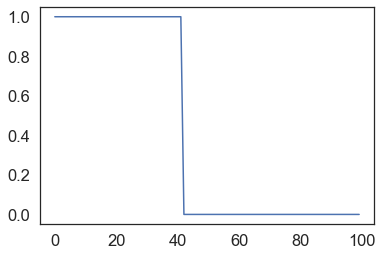

In [26]:
plt.plot(attractors)

In [9]:
import matplotlib.pyplot as plt
from ipywidgets import interact,fixed
import ipywidgets as widgets


def plot_frame(m,i):
    fig = plt.figure(figsize=(10,5))
    v = net.history[i]
    x = [memories.patterns[m][cell] for cell in memories.patterns[m].keys()]
    idxs = [cell for cell in memories.patterns[m].keys()]
    plt.scatter(x,v[idxs])

def plot_dynamics():
    interact(plot_frame,
             m = widgets.IntSlider(min=0, max=(len(memories.patterns)-1), value=0),
             i = widgets.IntSlider(min=0, max=(len(net.history)-1), value=0))




In [10]:
plot_dynamics()

interactive(children=(IntSlider(value=0, description='m', max=19), IntSlider(value=0, description='i', max=99)…

# SIMULATION

In [27]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 40 # P
CELLS_PER_PATTERN = 100 


DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

N_CHAINS = [1,2,4,5,10,20,40] # M
PATTERNS_PER_CHAIN = N_CHAINS[::-1] # Q

N_STEPS = 200 #number of dynamic steps
N_DRAWS = 20

In [28]:
simulation_data = {'M':[],'Q':[],'draw':[],'retrieval_quality':[],'obedience':[]}

for i in range(len(N_CHAINS)):
    n_chains = N_CHAINS[i]
    patterns_per_chain = PATTERNS_PER_CHAIN[i]
    print(f'Computing P={N_PATTERNS}, M={n_chains},Q={patterns_per_chain}')

    for d in tqdm(range(N_DRAWS)):

        #Memory structure
        kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
        memories = ps.PatternStructure(n_cells=N_CELLS,
                                    n_patterns=N_PATTERNS,
                                    cells_per_pattern=CELLS_PER_PATTERN,
                                    n_chains=n_chains,
                                    patterns_per_chain=patterns_per_chain,
                                    kernel=kernel)
        memories.generate_patterns()
        memories.generate_chains()
        memories.build_interactions()

        #initialize network
        net = nt.Network(J=memories.interaction_matrix, 
                        transfer_func=nt.ReLu,
                        dynamic_func=nt.net_dynamics)

        #run dynamics
        starting_map = np.random.choice(N_PATTERNS)
        initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
        initial_config = initial_config/np.mean(initial_config)
        net.run_dynamics(initial_config,n_steps=N_STEPS,sparsity=DYNAMIC_SPARISTY)

        coherence = fs.coherence_timecourse(memories,net.history)
        retrieved_sequence = fs.retrieved_sequence(memories,net.history)
        

        simulation_data['M'].append(n_chains)
        simulation_data['Q'].append(patterns_per_chain)
        simulation_data['draw'].append(d)
        simulation_data['retrieval_quality'].append(compute_retrieval_quality(coherence))
        simulation_data['obedience'].append(compute_obedience(retrieved_sequence,memories.chain_transitions))
        

    
simulation_data = pd.DataFrame(simulation_data)

    

  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=1,Q=40


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=2,Q=20


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=4,Q=10


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=5,Q=5


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=10,Q=4


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=20,Q=2


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=40,Q=1


100%|██████████| 20/20 [02:09<00:00,  6.47s/it]


In [29]:
simulation_data = pd.DataFrame(simulation_data)


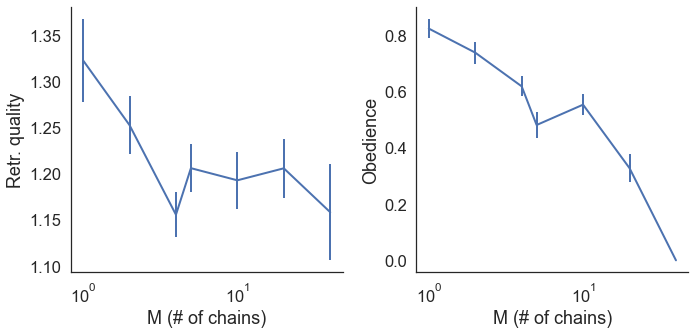

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['retrieval_quality']
err =  simulation_data.groupby('M').sem()['retrieval_quality']
plt.errorbar(x,y,err,linewidth=2)
plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Retr. quality')
sns.despine()

plt.subplot(1,2,2)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['obedience']
err =  simulation_data.groupby('M').sem()['obedience']
plt.errorbar(x,y,err,linewidth=2)
plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Obedience')

sns.despine()

plt.tight_layout()

# fixed lenght, more chains

In [33]:
# PARAMETERS
GAMMA = 0.5
XI = 0.1
N_CELLS = 1000
N_PATTERNS = 40 # P
CELLS_PER_PATTERN = 100 


DYNAMIC_SPARISTY = .2*(CELLS_PER_PATTERN/N_CELLS)

N_CHAINS = [1,2,4,5,10,20,40] # M
PATTERNS_PER_CHAIN = [30] # Q

N_STEPS = 200 #number of dynamic steps
N_DRAWS = 20

In [35]:
simulation_data = {'M':[],'Q':[],'draw':[],'retrieval_quality':[],'obedience':[]}

for i in range(len(N_CHAINS)):
    n_chains = N_CHAINS[i]
    patterns_per_chain = PATTERNS_PER_CHAIN[0]
    print(f'Computing P={N_PATTERNS}, M={n_chains},Q={patterns_per_chain}')

    for d in tqdm(range(N_DRAWS)):

        #Memory structure
        kernel = ps.InteractionKernel(gamma=GAMMA,xi=XI)
        memories = ps.PatternStructure(n_cells=N_CELLS,
                                    n_patterns=N_PATTERNS,
                                    cells_per_pattern=CELLS_PER_PATTERN,
                                    n_chains=n_chains,
                                    patterns_per_chain=patterns_per_chain,
                                    kernel=kernel)
        memories.generate_patterns()
        memories.generate_chains()
        memories.build_interactions()

        #initialize network
        net = nt.Network(J=memories.interaction_matrix, 
                        transfer_func=nt.ReLu,
                        dynamic_func=nt.net_dynamics)

        #run dynamics
        starting_map = np.random.choice(N_PATTERNS)
        initial_config = ps.build_correlated_activity(memories,starting_map,position=0.1)
        initial_config = initial_config/np.mean(initial_config)
        net.run_dynamics(initial_config,n_steps=N_STEPS,sparsity=DYNAMIC_SPARISTY)

        coherence = fs.coherence_timecourse(memories,net.history)
        retrieved_sequence = fs.retrieved_sequence(memories,net.history)
        

        simulation_data['M'].append(n_chains)
        simulation_data['Q'].append(patterns_per_chain)
        simulation_data['draw'].append(d)
        simulation_data['retrieval_quality'].append(compute_retrieval_quality(coherence))
        simulation_data['obedience'].append(compute_obedience(retrieved_sequence,memories.chain_transitions))
        

    
simulation_data = pd.DataFrame(simulation_data)

  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=1,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=2,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=4,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=5,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=10,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=20,Q=30


  0%|          | 0/20 [00:00<?, ?it/s]

Computing P=40, M=40,Q=30


100%|██████████| 20/20 [24:14<00:00, 72.73s/it]


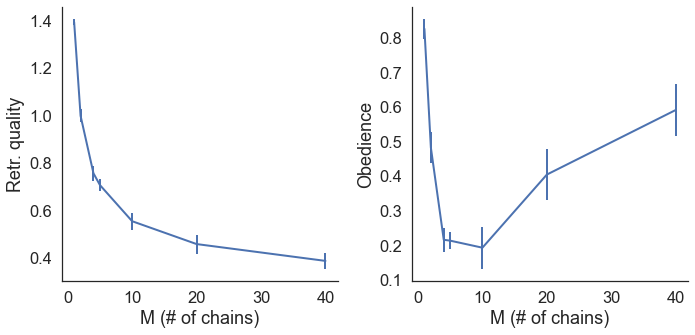

In [39]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['retrieval_quality']
err =  simulation_data.groupby('M').sem()['retrieval_quality']
plt.errorbar(x,y,err,linewidth=2)
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Retr. quality')
sns.despine()

plt.subplot(1,2,2)
x = np.unique(simulation_data['M'])
y = simulation_data.groupby('M').mean()['obedience']
err =  simulation_data.groupby('M').sem()['obedience']
plt.errorbar(x,y,err,linewidth=2)
#plt.xscale('log')
plt.xlabel('M (# of chains)')
plt.ylabel('Obedience')

sns.despine()

plt.tight_layout()